## Import Libraries

In [185]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.pipeline import Pipeline
from darts.models import TFTModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import StaticCovariatesTransformer, MissingValuesFiller

## Global Variables

In [180]:
TIME_COL = "Date"
TARGET = "Weekly_Sales"
STATIC_COV = ["Store", "Dept", "Type", "Size"]
DYNAMIC_COV_FILL_0 = ["IsHoliday", 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
DYNAMIC_COV_FILL_INTERPOLATE = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
FREQ = "W-FRI"
FORECAST_HORIZON = 16 # weeks
SCALER = Scaler()
TRANSFORMER = StaticCovariatesTransformer()
PIPELINE = Pipeline([SCALER, TRANSFORMER])

## Read and Preprocess data

In [181]:
# load data and exogenous features
df = pd.read_csv('data/train.csv')
store_info = pd.read_csv('data/stores.csv')
exo_feat = pd.read_csv('data/features.csv').drop(columns='IsHoliday')

# join all data frames
df = pd.merge(df, store_info, on=['Store'], how='left')
df = pd.merge(df, exo_feat, on=['Store', TIME_COL], how='left')

# process data
df[TIME_COL] = pd.to_datetime(df[TIME_COL])
df[TARGET] = np.where(df[TARGET] < 0, 0, df[TARGET]) # remove negative values
df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']] = df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']].fillna(0) # fill missing values with nan
df["IsHoliday"] = df["IsHoliday"]*1 # convert boolean into binary
df["Size"] = np.where(df["Size"] < store_info["Size"].quantile(0.25), "small",
                np.where(df["Size"] > store_info["Size"].quantile(0.75), "large",
                "medium")) # make size a categorical variable

# reduce running time by forecasting only top 7 stores
top_7_stores = df.groupby(['Store']).agg({TARGET: 'sum'}).reset_index().sort_values(by=TARGET, ascending=False).head(7)
df = df[df['Store'].isin(top_7_stores['Store'])]

## Split data into train and test

In [182]:
# 16 weeks to for test
train = df[df[TIME_COL] <= (max(df[TIME_COL])-timedelta(weeks=FORECAST_HORIZON))]
test = df[df[TIME_COL] > (max(df[TIME_COL])-timedelta(weeks=FORECAST_HORIZON))]

## Tranform data into Darts format

In [183]:
# read train and test datasets and transform train dataset
train_darts = TimeSeries.from_group_dataframe(df=train, group_cols=STATIC_COV, time_col=TIME_COL, value_cols=TARGET, freq=FREQ, fill_missing_dates=True, fillna_value=0)
test_darts = TimeSeries.from_group_dataframe(df=df, group_cols=STATIC_COV, time_col=TIME_COL, value_cols=TARGET, freq=FREQ, fill_missing_dates=True, fillna_value=0)

## Create Dynamic Covariates

In [186]:
# create dynamic covariates for each serie in the training darts
dynamic_covariates = []
for serie in train_darts:
    # add the month and week as a covariate
    covariate = datetime_attribute_timeseries(
        serie,
        attribute="month",
        one_hot=True,
        cyclic=False,
        add_length=FORECAST_HORIZON,
    )
    covariate = covariate.stack(
        datetime_attribute_timeseries(
            serie,
            attribute="week",
            one_hot=True,
            cyclic=False,
            add_length=FORECAST_HORIZON,
        )
    )
    
    store = serie.static_covariates['Store'].item()
    dept = serie.static_covariates['Dept'].item()

    # create covariates to fill with 0
    covariate = covariate.stack(
                TimeSeries.from_dataframe(df[(df['Store'] == store) & (df['Dept'] == dept)], time_col=TIME_COL, value_cols=DYNAMIC_COV_FILL_0, freq=FREQ, fill_missing_dates=True, fillna_value=0)
            )
    
    # create covariates to fill with interpolation
    dyn_cov_interp = TimeSeries.from_dataframe(df[(df['Store'] == store) & (df['Dept'] == dept)], time_col=TIME_COL, value_cols=DYNAMIC_COV_FILL_INTERPOLATE, freq=FREQ, fill_missing_dates=True)
    covariate = covariate.stack(MissingValuesFiller().transform(dyn_cov_interp))

    dynamic_covariates.append(covariate)

## Transform Data

In [192]:
# scale covariates
dynamic_covariates_transformed = SCALER.fit_transform(dynamic_covariates)

# scale data and transform static covariates
data_transformed = PIPELINE.fit_transform(train_darts)

## TFT

In [193]:
TFT_params = {
    "input_chunk_length": 52, # number of weeks to lookback
    "output_chunk_length": FORECAST_HORIZON,
    "hidden_size": 2,
    "lstm_layers": 2,
    "num_attention_heads": 1,
    "dropout": 0.1,
    "batch_size": 16,
    "n_epochs": 3,
    "likelihood": QuantileRegression(quantiles=[0.25, 0.5, 0.75]),
    "random_state": 42,
    "use_static_covariates": True,
    "optimizer_kwargs": {"lr": 1e-3},
}

tft_model = TFTModel(**TFT_params)
tft_model.fit(data_transformed, future_covariates=dynamic_covariates_transformed, verbose=False)
pred = PIPELINE.inverse_transform(tft_model.predict(n=FORECAST_HORIZON, series=data_transformed, num_samples=50, future_covariates=dynamic_covariates_transformed))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=3` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 31/31 [01:40<00:00,  0.31it/s]


## Explainability

In [195]:
from darts.explainability import TFTExplainer

explainer = TFTExplainer(
    tft_model,
    background_series=data_transformed[1],
    background_future_covariates=dynamic_covariates_transformed[1],
)
explainability_result = explainer.explain()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


### Encoder Importance

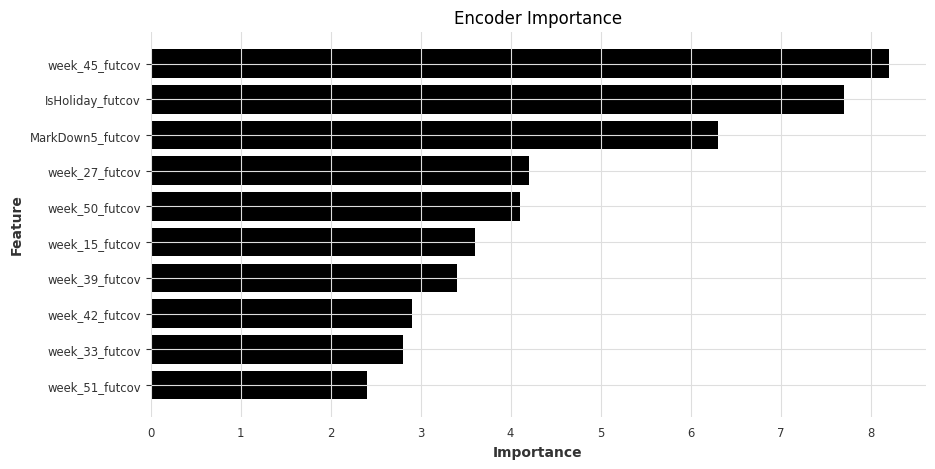

In [196]:
plt.rcParams["figure.figsize"] = (10,5)
plt.barh(data=explainer._encoder_importance.melt().sort_values(by='value').tail(10), y='variable', width='value')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Encoder Importance')
plt.show()

### Decoder Importance

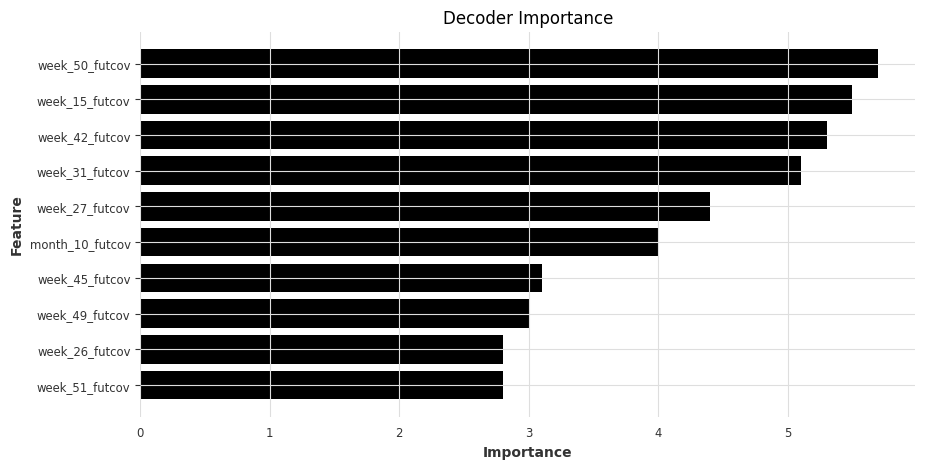

In [197]:
plt.rcParams["figure.figsize"] = (10,5)
plt.barh(data=explainer._decoder_importance.melt().sort_values(by='value').tail(10), y='variable', width='value')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Decoder Importance')
plt.show()

### Static Cov Importance

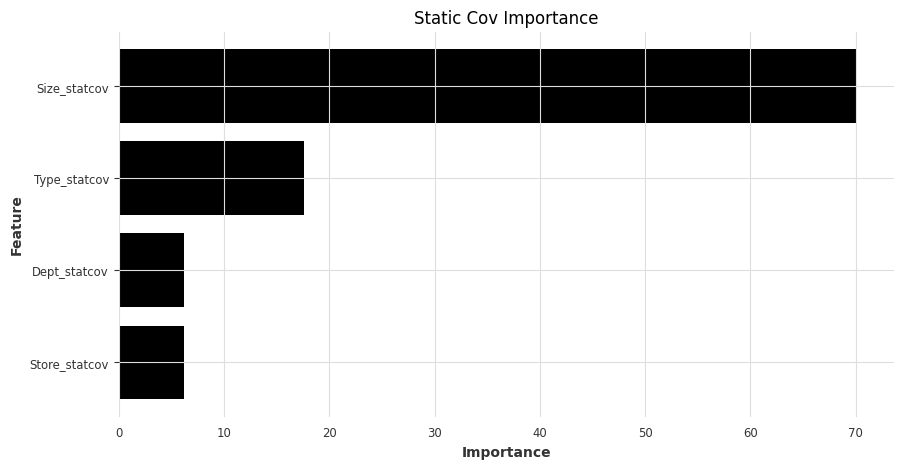

In [198]:
plt.rcParams["figure.figsize"] = (10,5)
plt.barh(data=explainer._static_covariates_importance.melt().sort_values(by='value').tail(10), y='variable', width='value')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Static Cov Importance')
plt.show()

### Time Importance

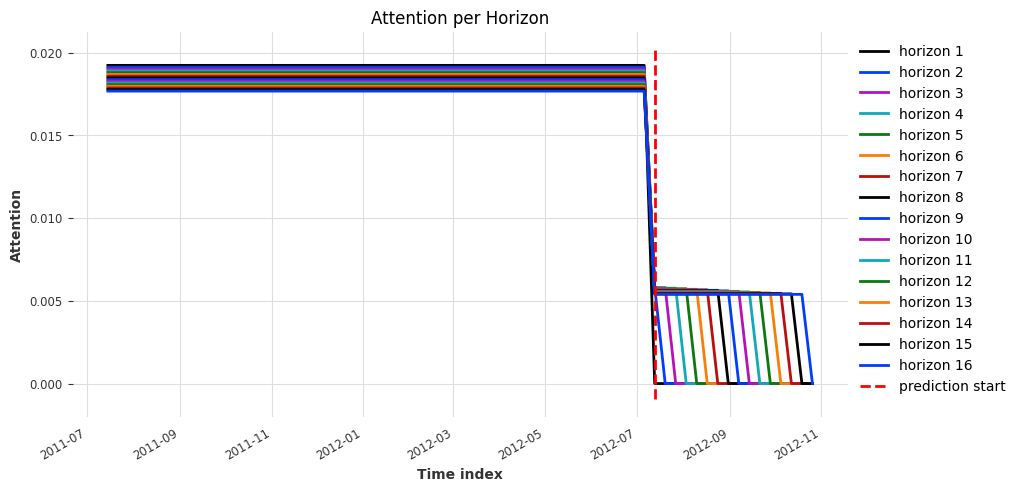

<Axes: title={'center': 'Attention per Horizon'}, xlabel='Time index', ylabel='Attention'>

In [199]:
explainer.plot_attention(explainability_result, plot_type="all", show_index_as='time')

## Performance Evaluation

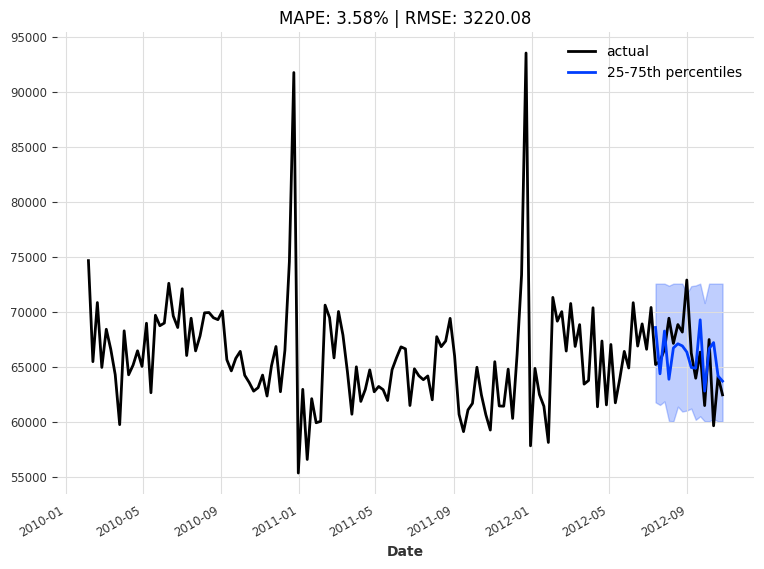

In [200]:
from darts.metrics import mape, rmse

def eval_model(val_series, pred_series):

    # plot actual series
    plt.figure(figsize=(9, 6))
    val_series[: pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(
        low_quantile=0.25, high_quantile=0.75, label=f"{int(0.25 * 100)}-{int(0.75 * 100)}th percentiles"
    )

    plt.title(f"MAPE: {round(mape(val_series, pred_series),2)}% | RMSE: {round(rmse(val_series, pred_series),2)}")
    plt.legend()

eval_model(test_darts[1], pred[1])